In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator
from keras._tf_keras.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras._tf_keras.keras import Input, Sequential
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.losses import BinaryCrossentropy
from keras._tf_keras.keras.optimizers import Adam
from keras._tf_keras.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Data augmentation and preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/train',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/test',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical')


Found 2570 images belonging to 18 classes.
Found 893 images belonging to 18 classes.


In [4]:
path = '/content/drive/MyDrive/Dataset/train'

In [5]:
class_names = sorted(os.listdir(path))
num_classes = len(class_names)

img_size = (192, 192, 3)

print(os.listdir('/content/drive/MyDrive/Dataset'))
print(os.listdir('/content/drive/MyDrive/Dataset/train'))

['test', 'train']
['Seborrheic Keratoses and other Benign Tumors', 'Systemic Disease', 'Warts Molluscum and other Viral Infections', 'Tinea Ringworm Candidiasis and other Fungal Infections', 'Psoriasis pictures Lichen Planus and related diseases', 'Vasculitis Photos', 'Vascular Tumors', 'Poison Ivy Photos and other Contact Dermatitis', 'Melanoma Skin Cancer Nevi and Moles', 'Lupus and other Connective Tissue diseases', 'Light Diseases and Disorders of Pigmentation', 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions', 'Acne and Rosacea Photos', 'Exanthems and Drug Eruptions', 'Eczema Photos', 'Herpes HPV and other STDs Photos', 'Atopic Dermatitis Photos', 'Cellulitis Impetigo and other Bacterial Infections']


In [6]:
import cv2
import os
import numpy as np

path = '/content/drive/MyDrive/Dataset/train'
class_names = sorted(os.listdir(path))
num_classes = len(class_names)
img_size = (192, 192, 3)

labels = []
images = []

print('images:\n')
for cl in class_names:
    print(cl, end=' -> ')
    class_path = os.path.join(path, cl)
    for img in os.listdir(class_path):
        label = np.zeros(num_classes)
        label[class_names.index(cl)] = 1
        labels.append(label)

        image = np.asarray(
            cv2.resize(
                cv2.imread(os.path.join(class_path, img), cv2.IMREAD_COLOR),
                img_size[0:2]
            )[:, :, ::-1]
        )
        images.append(image)
    print('done')

labels = np.asarray(labels)
images = np.asarray(images)

print(f'\nlabels shape: {labels.shape}')
print(f'images shape: {images.shape}')

images:

Acne and Rosacea Photos -> done
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions -> done
Atopic Dermatitis Photos -> done
Cellulitis Impetigo and other Bacterial Infections -> done
Eczema Photos -> done
Exanthems and Drug Eruptions -> done
Herpes HPV and other STDs Photos -> done
Light Diseases and Disorders of Pigmentation -> done
Lupus and other Connective Tissue diseases -> done
Melanoma Skin Cancer Nevi and Moles -> done
Poison Ivy Photos and other Contact Dermatitis -> done
Psoriasis pictures Lichen Planus and related diseases -> done
Seborrheic Keratoses and other Benign Tumors -> done
Systemic Disease -> done
Tinea Ringworm Candidiasis and other Fungal Infections -> done
Vascular Tumors -> done
Vasculitis Photos -> done
Warts Molluscum and other Viral Infections -> done

labels shape: (2570, 18)
images shape: (2570, 192, 192, 3)


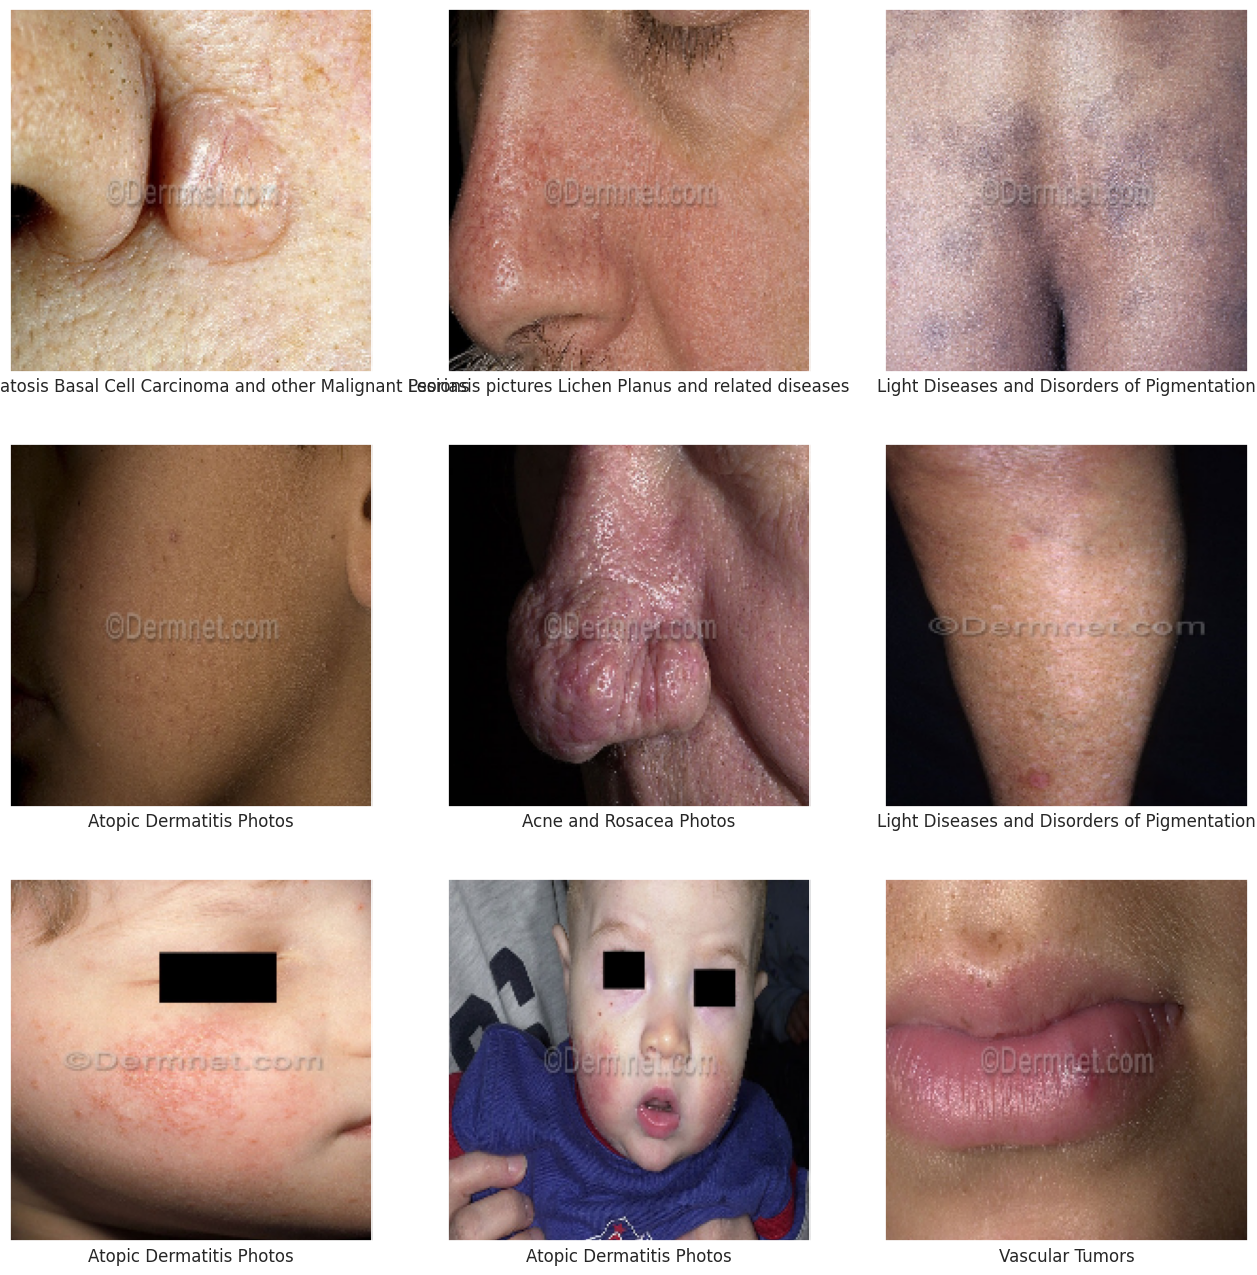

In [8]:
from random import randint

fig, axs = plt.subplots(3, 3, figsize=(16, 16))#Original was 10,6

for x in range(3):
    for y in range(3):
        i = randint(0, len(images))

        axs[x][y].imshow(images[i])


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(class_names[np.argmax(labels[i])])


plt.show()

In [9]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.15, random_state=42)

print(f'train images shape: {X_train.shape}\ntrain labels shape: {y_train.shape}\n\nvalidation images shape: {X_val.shape}\nvalidation labels shape: {y_val.shape}\n')

train images shape: (2184, 192, 192, 3)
train labels shape: (2184, 18)

validation images shape: (386, 192, 192, 3)
validation labels shape: (386, 18)



In [10]:
cnn_model = tf.keras.Sequential()

# Inputs and rescaling
cnn_model.add(tf.keras.layers.Rescaling(scale=1. / 255, input_shape=(img_size)))

# Convolutional block 1
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 2
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 3
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(256, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))

# Convolutional block 4
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.Conv2D(512, (2, 2), activation='relu', padding='same'))
cnn_model.add(tf.keras.layers.MaxPooling2D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())

# Dense block
cnn_model.add(tf.keras.layers.Dense(256, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(128, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(64, activation='relu'))
cnn_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))


cnn_model.compile(optimizer='Adamax', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 192, 192, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 192, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 128)    │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 256)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 256)    │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 512)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 512)    │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 18)             │         1,170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,021,842 (80.19 MB)

 Trainable params: 21,021,842 (80.19 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# creating ModelChecpoint callback
checkpoint_callback = ModelCheckpoint('cnn_model/model{epoch:02d}.keras', save_best_only=True)

In [13]:
history = cnn_model.fit(images, labels, epochs=14, validation_data=(X_val, y_val), callbacks=[checkpoint_callback])

Epoch 1/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1605s 20s/step - accuracy: 0.3209 - loss: 2.3885 - val_accuracy: 0.3135 - val_loss: 2.3297
Epoch 2/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1648s 20s/step - accuracy: 0.3176 - loss: 2.3447 - val_accuracy: 0.3264 - val_loss: 2.2611
Epoch 3/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1645s 20s/step - accuracy: 0.3193 - loss: 2.2759 - val_accuracy: 0.3212 - val_loss: 2.2525
Epoch 4/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1618s 20s/step - accuracy: 0.3519 - loss: 2.2107 - val_accuracy: 0.3446 - val_loss: 2.1777
Epoch 5/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1608s 20s/step - accuracy: 0.3379 - loss: 2.1737 - val_accuracy: 0.3342 - val_loss: 2.1720
Epoch 6/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1612s 19s/step - accuracy: 0.3604 - loss: 2.1176 - val_accuracy: 0.3679 - val_loss: 2.0791
Epoch 7/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1619s 20s/step - accuracy: 0.3769 - loss: 2.0573 - val_accuracy: 0.4041 - val_loss: 1.9808
Epoch 8/14
81/81 ━━━━━━━━━━━━━━━━━━━━ 1609s 20s/step - accuracy: 0.4438 - loss: 1.8602 - val_accu

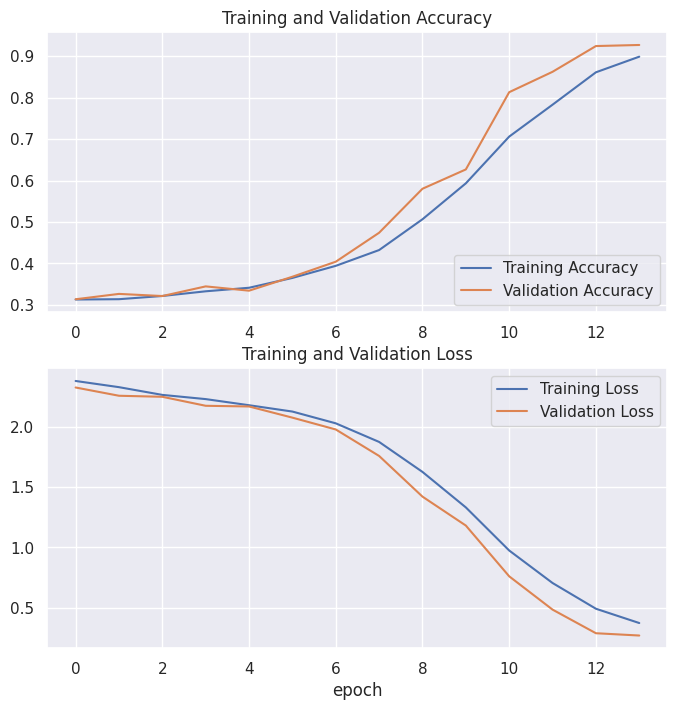

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [15]:
from sklearn.metrics import classification_report

# === LANGKAH 1: Prediksi data validasi ===
predicted_probabilities = cnn_model.predict(X_val)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
true_classes = np.argmax(y_val, axis=1)  # karena y_val dalam format one-hot

# === LANGKAH 2: Classification Report ===
report = classification_report(true_classes, predicted_classes, target_names=class_names)

print("📊 Classification Report:")
print(report)

13/13 ━━━━━━━━━━━━━━━━━━━━ 68s 5s/step
📊 Classification Report:
                                                                    precision    recall  f1-score   support

                                           Acne and Rosacea Photos       0.90      0.98      0.94       121
Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions       0.95      0.95      0.95        44
                                          Atopic Dermatitis Photos       1.00      0.94      0.97        18
                Cellulitis Impetigo and other Bacterial Infections       1.00      0.78      0.88         9
                                                     Eczema Photos       0.75      1.00      0.86         3
                                      Exanthems and Drug Eruptions       1.00      1.00      1.00         4
                                  Herpes HPV and other STDs Photos       0.83      0.71      0.77         7
                      Light Diseases and Disorders of Pigmentation     

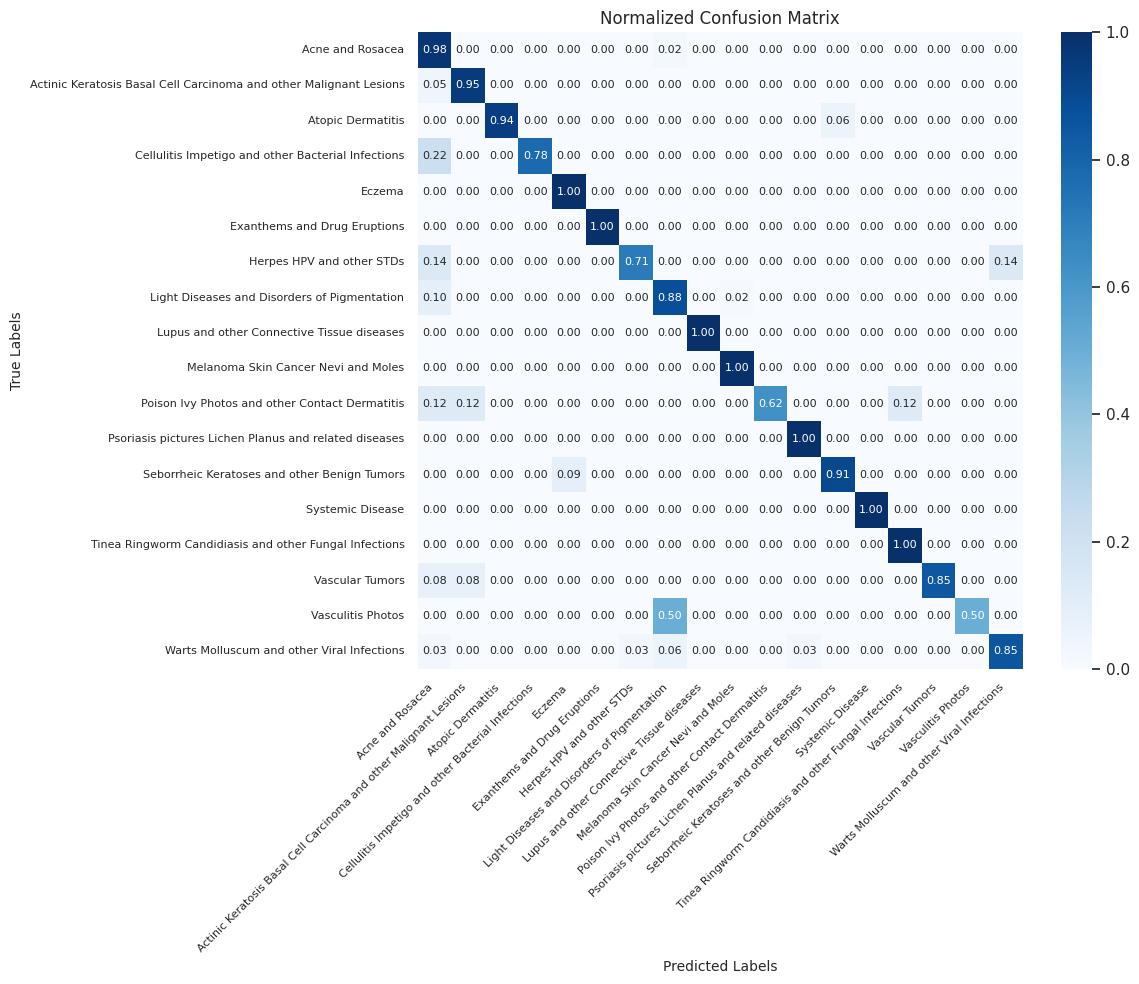

In [63]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalisasi per baris
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            fmt='.2f', annot_kws={"size": 8})  # Ukuran angka lebih kecil

# Label dan tampilan
plt.xlabel('Predicted Labels', fontsize=10)
plt.ylabel('True Labels', fontsize=10)
plt.title('Normalized Confusion Matrix', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

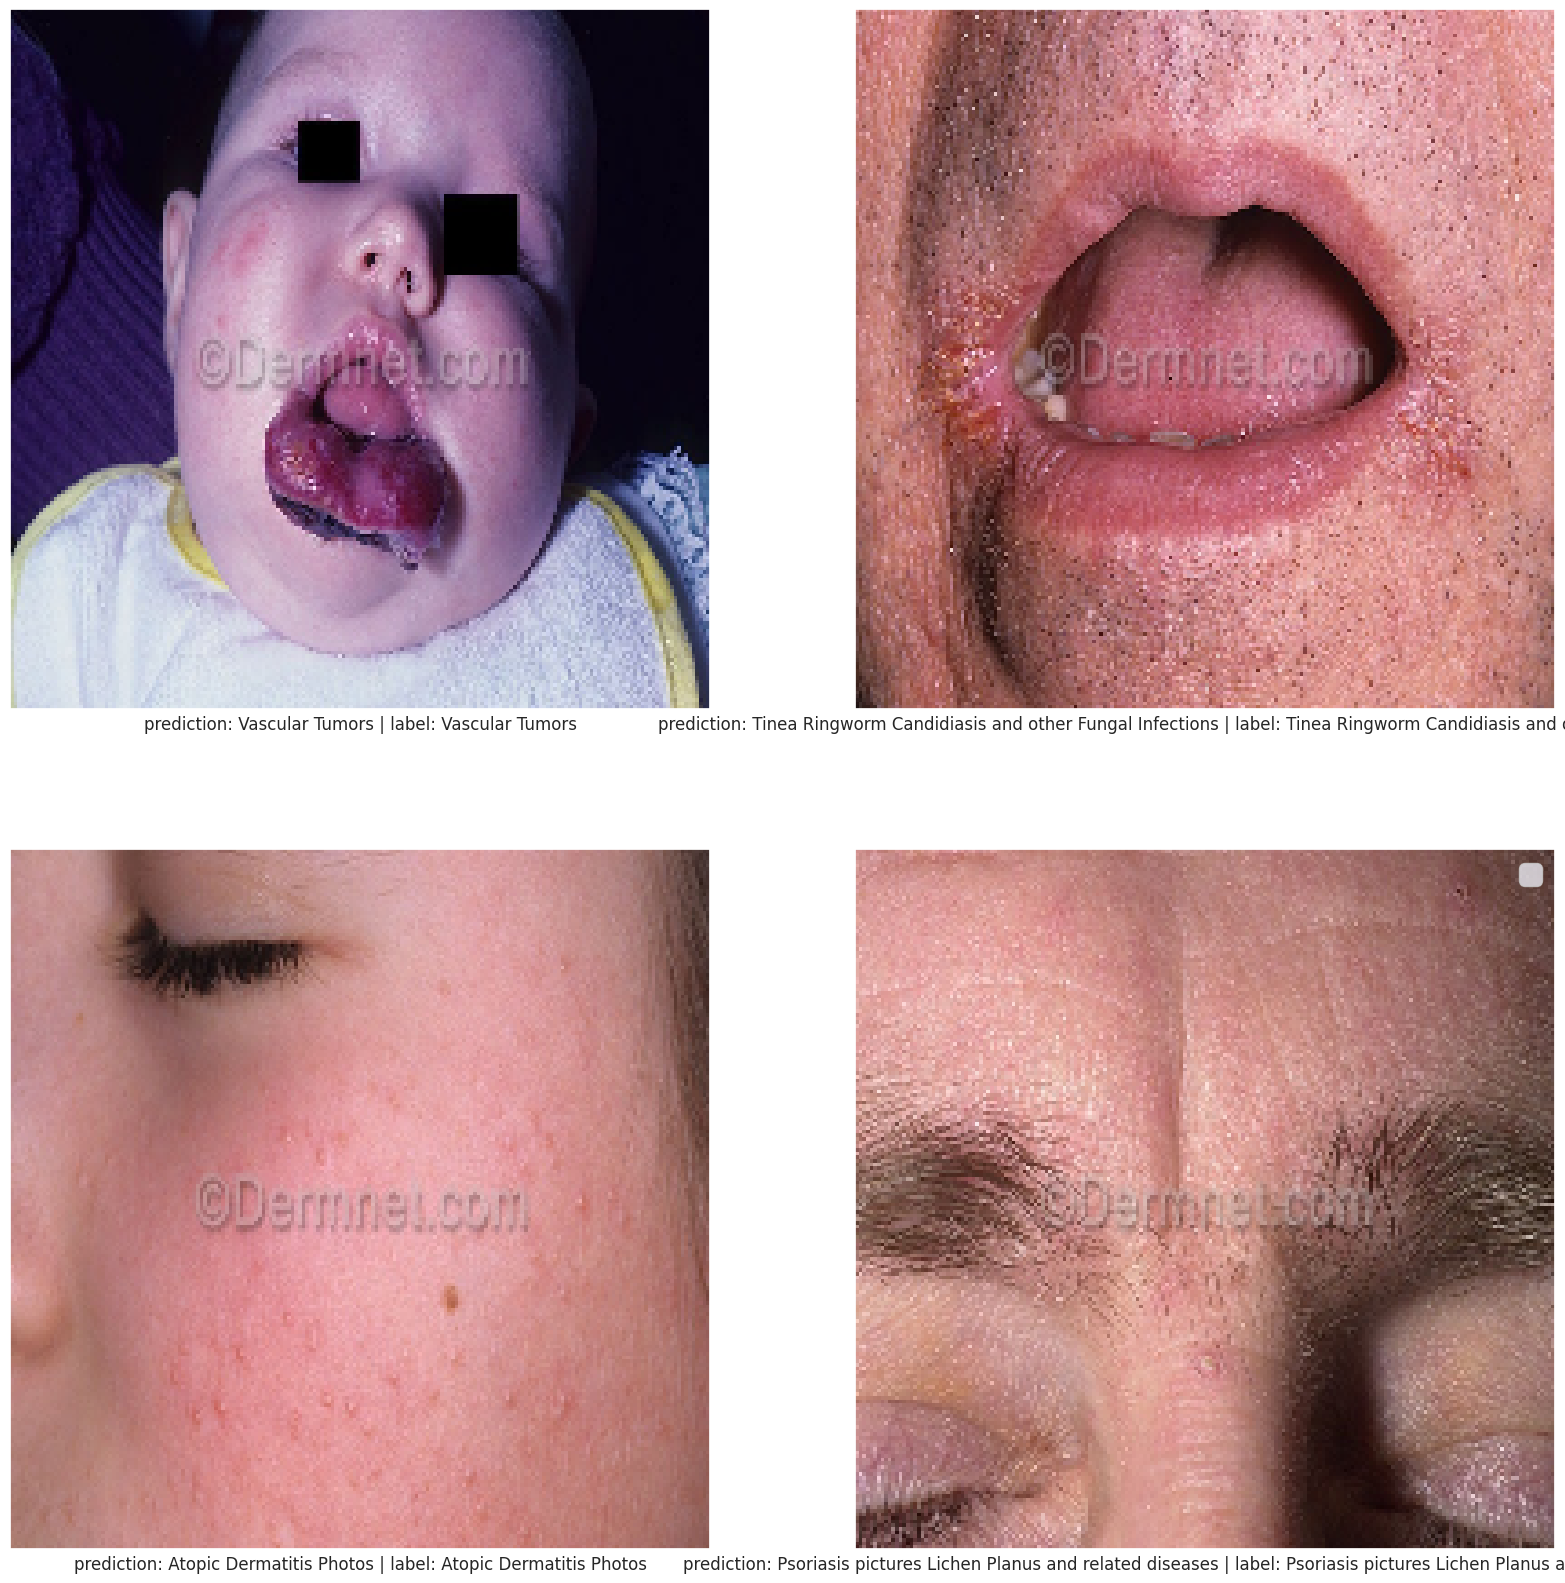

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))#Original was 7,4 (28 is higher than 25) and figsize 15,15
plt.legend(fontsize="20")#I can't read any of them

i = 0
for x in range(2): #Original was 7 so resulted in error 7X4 = 28
    for y in range(2):
        prediction = cnn_model.predict(X_val[i][None, ...], verbose=0)[0],


        axs[x][y].set_xticks([])
        axs[x][y].set_yticks([])
        axs[x][y].set_xlabel(f'prediction: {class_names[np.argmax(prediction)]} | label: {class_names[np.argmax(y_val[i])]}')

        axs[x][y].imshow(X_val[i])

        i += 1
plt.show()

In [69]:
cnn_model.save('/content/drive/MyDrive/cnn_model.h5')